# Motor Remaining Useful Life (RUL) Prediction: Baseline Pipeline

This notebook demonstrates a baseline approach for predicting the Remaining Useful Life (RUL) of motors using a dataset similar to NASA C-MAPSS. The workflow includes data loading, feature engineering, model training (XGBoost), and evaluation. 

---

**Outline:**
1. Import libraries and load data
2. Initial data analysis and visualization
3. Add RUL target variable
4. Aggregate features with rolling window
5. Feature engineering: derivatives, rolling stats, PCA
6. Train/test split
7. Baseline XGBoost model
8. Model evaluation and error analysis
9. (Optional) Data preparation for LSTM/GRU (sliding window)


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import catboost
import xgboost as xgb
import shap
# Load the dataset
df = pd.read_csv('../data/Data.csv')

# Display the first few rows
df.head()

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,id,cycle,p00,p01,p02,p03,p04,p05,p06,p07,...,p13,p14,p15,p16,p17,p18,p19,p20,s1,s2
0,1,1,518.67,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,...,23.4190,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,-0.0007,-0.0004
1,1,2,518.67,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,...,23.4236,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,0.0019,-0.0003
2,1,3,518.67,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,...,23.3442,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,-0.0043,0.0003
3,1,4,518.67,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,...,23.3739,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,0.0007,0.0000
4,1,5,518.67,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,...,23.4044,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,-0.0019,-0.0002


## 1. Initial Data Analysis and Visualization

- Check data structure, types, and missing values
- Visualize cycle and sensor distributions


In [2]:
df.columns

Index(['id', 'cycle', 'p00', 'p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p07',
       'p08', 'p09', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17',
       'p18', 'p19', 'p20', 's1', 's2'],
      dtype='object')

In [3]:
# Show dataframe info and check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16138 entries, 0 to 16137
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      16138 non-null  int64  
 1   cycle   16138 non-null  int64  
 2   p00     16138 non-null  float64
 3   p01     16138 non-null  float64
 4   p02     16138 non-null  float64
 5   p03     16138 non-null  float64
 6   p04     16138 non-null  float64
 7   p05     16138 non-null  float64
 8   p06     16138 non-null  float64
 9   p07     16138 non-null  float64
 10  p08     16138 non-null  int64  
 11  p09     16138 non-null  int64  
 12  p10     16138 non-null  int64  
 13  p11     16138 non-null  float64
 14  p12     16138 non-null  float64
 15  p13     16138 non-null  float64
 16  p14     16138 non-null  float64
 17  p15     16138 non-null  float64
 18  p16     16138 non-null  float64
 19  p17     16138 non-null  float64
 20  p18     16138 non-null  float64
 21  p19     16138 non-null  float64
 22

In [4]:
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
id       0
cycle    0
p00      0
p01      0
p02      0
p03      0
p04      0
p05      0
p06      0
p07      0
p08      0
p09      0
p10      0
p11      0
p12      0
p13      0
p14      0
p15      0
p16      0
p17      0
p18      0
p19      0
p20      0
s1       0
s2       0
dtype: int64


In [5]:
# Show basic statistics. Sensors p01 and p00, p07, p09, p10, p16 and p17 are not changed
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,16138.0,4.070789e+01,2.339535e+01,1.0000,20.0000,42.0000,61.0000,80.0000
cycle,16138.0,1.055481e+02,6.591530e+01,1.0000,51.0000,101.0000,153.0000,362.0000
p00,16138.0,5.186700e+02,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
p01,16138.0,1.300000e+00,2.220515e-16,1.3000,1.3000,1.3000,1.3000,1.3000
p02,16138.0,4.754426e+01,2.674218e-01,46.8600,47.3500,47.5200,47.7100,48.5300
p03,16138.0,5.214054e+02,7.382523e-01,518.6900,520.9400,521.4600,521.9400,523.3800
p04,16138.0,2.388097e+03,7.260372e-02,2387.8800,2388.0400,2388.0900,2388.1400,2388.5600
p05,16138.0,8.143933e+03,1.973135e+01,8099.9400,8132.8300,8140.7500,8148.8175,8293.7200
p06,16138.0,8.442581e+00,3.751962e-02,8.3249,8.4153,8.4398,8.4660,8.5848
p07,16138.0,3.000000e-02,1.387822e-17,0.0300,0.0300,0.0300,0.0300,0.0300


In [6]:
df = df.drop(columns=['p01', 'p00', 'p07', 'p09', 'p10', 'p16', 'p17'])

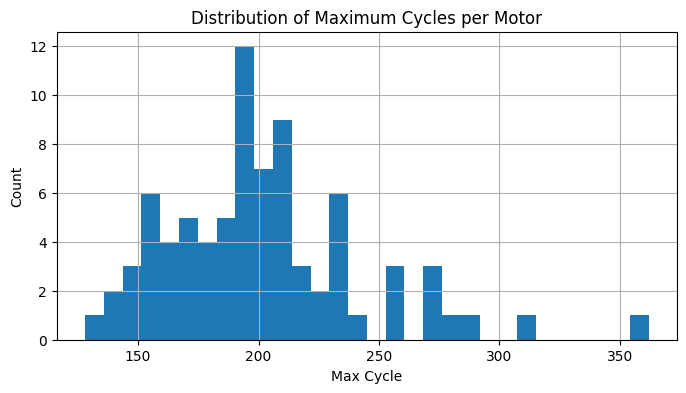

In [7]:
# Plot distribution of cycles per motor
plt.figure(figsize=(8,4))
df.groupby('id')['cycle'].max().hist(bins=30)
plt.title('Distribution of Maximum Cycles per Motor')
plt.xlabel('Max Cycle')
plt.ylabel('Count')
plt.show()

## 2. Add RUL (Remaining Useful Life) Target Variable

- For each motor, calculate RUL as the difference between the maximum cycle and the current cycle.


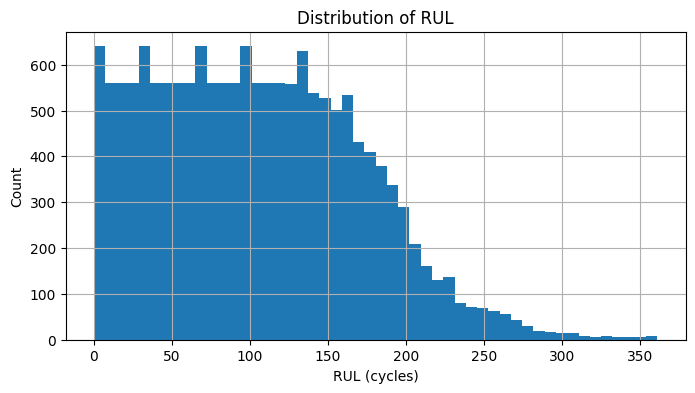

,id,cycle,p02,p03,p04,p05,p06,p08,p11,p12,p13,p14,p15,p18,p19,p20,s1,s2,rul
0,1,1,47.47,521.66,2388.02,8138.62,8.4195,392,641.82,39.06,23.4190,1589.70,1400.60,554.36,2388.06,9046.19,-0.0007,-0.0004,191
1,1,2,47.49,522.28,2388.07,8131.49,8.4318,392,642.15,39.00,23.4236,1591.82,1403.14,553.75,2388.04,9044.07,0.0019,-0.0003,190
2,1,3,47.27,522.42,2388.03,8133.23,8.4178,390,642.35,38.95,23.3442,1587.99,1404.20,554.26,2388.08,9052.94,-0.0043,0.0003,189
3,1,4,47.13,522.86,2388.08,8133.83,8.3682,392,642.35,38.88,23.3739,1582.79,1401.87,554.45,2388.11,9049.48,0.0007,0.0000,188
4,1,5,47.28,522.19,2388.04,8133.80,8.4294,393,642.37,38.90,23.4044,1582.85,1406.22,554.00,2388.06,9055.15,-0.0019,-0.0002,187


In [8]:
# Calculate RUL for each row 
df['max_cycle'] = df.groupby('id')['cycle'].transform('max')
df['rul'] = df['max_cycle'] - df['cycle']
df.drop('max_cycle', axis=1, inplace=True)

# Plot RUL distribution
plt.figure(figsize=(8,4))
df['rul'].hist(bins=50)
plt.title('Distribution of RUL')
plt.xlabel('RUL (cycles)')
plt.ylabel('Count')
plt.show()

df.head()

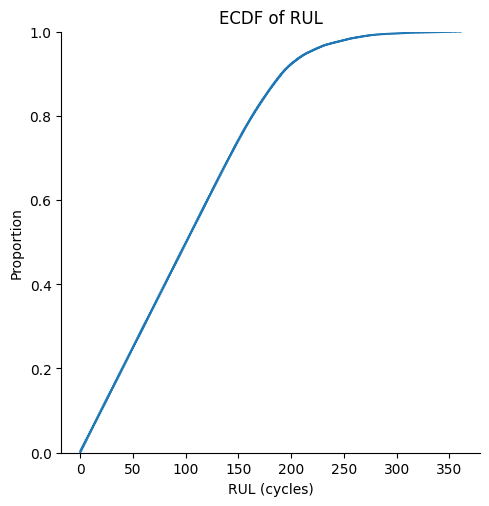

In [9]:
# ECDF plot for RUL (Remaining Useful Life)
#This plot shows the ECDF (Empirical Cumulative Distribution Function) of RUL. 
# It helps us see the distribution of remaining useful life for all engines.
import seaborn as sns
import matplotlib.pyplot as plt

sns.displot(data=df, x='rul', kind='ecdf')
plt.title('ECDF of RUL')
plt.xlabel('RUL (cycles)')
plt.ylabel('Proportion')
plt.show()

In [10]:
# Check correlation with RUL. There are p03, p04, p05, p06, p07, p08, p09, p10, and p11 that are highly correlated with RUL.
df.corr()['rul'].sort_values(ascending=False)

rul      1.000000
p03      0.678935
p18      0.662448
p13      0.646511
p12      0.637581
id       0.028491
s1      -0.000150
s2      -0.002669
p05     -0.310472
p20     -0.391014
p19     -0.566356
p04     -0.566580
p14     -0.590030
p08     -0.613475
p11     -0.616728
p06     -0.648625
p15     -0.686511
p02     -0.704527
cycle   -0.769964
Name: rul, dtype: float64

In [11]:
# Column like as the cycle is time series data, so we need to create rolling features

# Note: When you create rolling window features, the first (window_size-1) rows for each engine will have NaN values.
# This is normal because there is not enough history for the window.
# To use PCA or any model that does not support NaN, you should fill these NaN values.
# The most common way is to fill NaN with the mean or median of the column.

sensor_cols = [col for col in df.columns if col.startswith('p') or col.startswith('s')]
sensor_cols

['p02',
 'p03',
 'p04',
 'p05',
 'p06',
 'p08',
 'p11',
 'p12',
 'p13',
 'p14',
 'p15',
 'p18',
 'p19',
 'p20',
 's1',
 's2']

## 3. Aggregate Features with Rolling Window

- For each motor and each cycle, compute rolling window aggregates (mean, std, min, max) for sensor features over the last N cycles (e.g., N=30).
- This helps capture recent trends and variability for each engine.


In [12]:
# Column like as the cycle is time series data, so we need to create rolling features

# Note: When you create rolling window features, the first (window_size-1) rows for each engine will have NaN values.
# This is normal because there is not enough history for the window.
# To use PCA or any model that does not support NaN, you should fill these NaN values.
# The most common way is to fill NaN with the mean or median of the column.

# Add difference features for each sensor column
for col in sensor_cols:
    df[f'{col}_diff1'] = df.groupby('id')[col].diff()

def add_rolling_features(df, cols, window):
    """ 
    Function to add rolling features for each column in cols
    using a specified window size.
    """
    new_features = {}
    for func in ['mean', 'std', 'min', 'max']:
        for col in sensor_cols:
            new_features[f'{col}_roll{window}_{func}'] = (
                df.groupby('id')[col].transform(lambda x: x.rolling(window, min_periods=1).agg(func))
            )
    df = pd.concat([df, pd.DataFrame(new_features)], axis=1)
    df = df.copy()  # Defragment the DataFrame
    # Fill NaN values with the mean of the column
    for col in new_features.keys():
        df[col] = df[col].fillna(df[col].mean())
    return df

windows = [5, 10, 20, 30, 45, 60, 90, 120, 180, 350]
# Add rolling features for each window size
for window in windows:
    df = add_rolling_features(df, sensor_cols, window)

df[[c for c in df.columns if 'roll' in c]].head()

,p02_roll5_mean,p03_roll5_mean,p04_roll5_mean,p05_roll5_mean,p06_roll5_mean,p08_roll5_mean,p11_roll5_mean,p12_roll5_mean,p13_roll5_mean,p14_roll5_mean,...,p11_roll350_max,p12_roll350_max,p13_roll350_max,p14_roll350_max,p15_roll350_max,p18_roll350_max,p19_roll350_max,p20_roll350_max,s1_roll350_max,s2_roll350_max
0,47.470,521.660,2388.020,8138.620000,8.419500,392.000000,641.820000,39.060000,23.419000,1589.700000,...,641.82,39.06,23.4190,1589.70,1400.60,554.36,2388.06,9046.19,-0.0007,-0.0004
1,47.480,521.970,2388.045,8135.055000,8.425650,392.000000,641.985000,39.030000,23.421300,1590.760000,...,642.15,39.06,23.4236,1591.82,1403.14,554.36,2388.06,9046.19,0.0019,-0.0003
2,47.410,522.120,2388.040,8134.446667,8.423033,391.333333,642.106667,39.003333,23.395600,1589.836667,...,642.35,39.06,23.4236,1591.82,1404.20,554.36,2388.08,9052.94,0.0019,0.0003
3,47.340,522.305,2388.050,8134.292500,8.409325,391.500000,642.167500,38.972500,23.390175,1588.075000,...,642.35,39.06,23.4236,1591.82,1404.20,554.45,2388.11,9052.94,0.0019,0.0003
4,47.328,522.282,2388.048,8134.194000,8.413340,391.800000,642.208000,38.958000,23.393020,1587.030000,...,642.37,39.06,23.4236,1591.82,1406.22,554.45,2388.11,9055.15,0.0019,0.0003


In [13]:
def add_rolling_trend(df, cols, window):
    """
    Function to add rolling trend features for each column in cols
    using a specified window size.
    The trend is calculated using a linear regression fit (slope).
    
    """
    def trend(x):
        idx = np.arange(len(x))
        if len(x) < 2:
            return 0.0
        return np.polyfit(idx, x, 1)[0]
    new_features = {}
    for col in cols:
        new_features[f'{col}_roll{window}_trend'] = (
            df.groupby('id')[col]
              .transform(lambda x: x.rolling(window, min_periods=2).apply(trend, raw=True))
        )
    df = pd.concat([df, pd.DataFrame(new_features, index=df.index)], axis=1)
    df = df.copy()  # дефрагментация
    return df

# Пример: только окна 30 и 90, только первые 5 сенсоров
trend_windows = [30, 90]
trend_sensor_cols = sensor_cols[:5]  # или выберите самые важные

for w in trend_windows:
    df = add_rolling_trend(df, trend_sensor_cols, w)

## 4. Feature Engineering: Derivatives, Rolling Statistics, PCA

- Add first-order differences (derivatives) for sensor features.
- Optionally, apply PCA to reduce dimensionality of rolling features.


In [14]:
from sklearn.impute import SimpleImputer

rolling_cols = [c for c in df.columns if 'roll' in c or 'diff1' in c]
imputer = SimpleImputer(strategy='mean')
df[rolling_cols] = imputer.fit_transform(df[rolling_cols])

## 5. Train/Test Split

- Split the data into training and test sets. We will use the last 20 cycles of each engine as the test set. The rest will be used for training.


In [15]:
from sklearn.model_selection import train_test_split

# Create bins for RUL to stratify the split
# This helps to ensure that both training and test sets have a similar distribution of RUL values
# We use pd.qcut to create quantile-based bins, which helps in stratifying the split
# The 'duplicates' parameter is set to 'drop' to avoid issues with bins that have the same edges
# This is useful when the RUL values are not evenly distributed

# get unique engine ids
unique_ids = df['id'].unique()
unique_ids

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80])

In [16]:
# Create bins for RUL to stratify the split
id_rul = df.groupby('id')['rul'].max().reset_index()
id_rul['rul_bin'] = pd.qcut(id_rul['rul'], q=10, duplicates='drop')
id_rul['rul_bin']

0       (179.7, 191.0]
1       (256.2, 361.0]
2       (166.6, 179.7]
3       (179.7, 191.0]
4       (256.2, 361.0]
            ...       
75      (201.0, 212.0]
76    (126.999, 154.8]
77      (229.2, 256.2]
78      (194.5, 201.0]
79      (179.7, 191.0]
Name: rul_bin, Length: 80, dtype: category
Categories (10, interval[float64, right]): [(126.999, 154.8] < (154.8, 166.6] < (166.6, 179.7] < (179.7, 191.0] ... (201.0, 212.0] < (212.0, 229.2] < (229.2, 256.2] < (256.2, 361.0]]

In [17]:
# Split the data into training and test sets, stratifying by the RUL bins
train_ids, test_ids = train_test_split(
    id_rul['id'],
    test_size=0.2,
    random_state=42,
    stratify=id_rul['rul_bin']
)

In [18]:
# Form train and test sets based on the selected ids
train_df = df[df['id'].isin(train_ids)].copy()
test_df = df[df['id'].isin(test_ids)].copy()

print(train_df['rul'].describe())
print(test_df['rul'].describe())

count    12950.000000
mean       105.060541
std         66.524506
min          0.000000
25%         50.000000
50%        101.000000
75%        152.000000
max        361.000000
Name: rul, dtype: float64
count    3188.000000
mean      102.466750
std        63.347968
min         0.000000
25%        49.000000
50%        99.000000
75%       149.000000
max       282.000000
Name: rul, dtype: float64


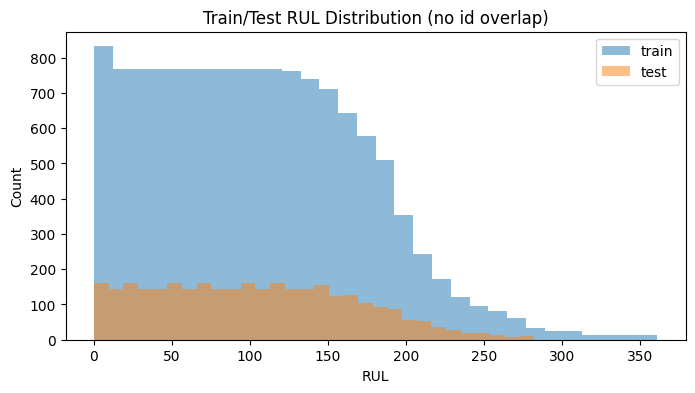

In [19]:
# Visualize the distribution of RUL in train and test sets
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(train_df['rul'], bins=30, alpha=0.5, label='train')
plt.hist(test_df['rul'], bins=30, alpha=0.5, label='test')
plt.xlabel('RUL')
plt.ylabel('Count')
plt.legend()
plt.title('Train/Test RUL Distribution (no id overlap)')
plt.show()

In [20]:
from scipy.stats import ks_2samp

stat, p_value = ks_2samp(train_df['rul'], test_df['rul'])
print(f"KS statistic: {stat:.4f}, p-value: {p_value:.4f}")

if p_value > 0.05:
    print("rul distributions in train and test are statistically similar.")
else:
    print("rul distributions in train and test are statistically different.")



KS statistic: 0.0152, p-value: 0.5918
rul distributions in train and test are statistically similar.


In [21]:
test_df['id'].unique()

array([21, 23, 25, 26, 27, 33, 35, 40, 46, 52, 58, 63, 64, 72, 77, 78])

In [22]:
train_df['id'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 22, 24, 28, 29, 30, 31, 32, 34, 36, 37, 38, 39, 41, 42,
       43, 44, 45, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 59, 60, 61, 62,
       65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 79, 80])

## 6. Baseline XGBoost Model

- We will train a simple XGBoost model to predict RUL. We use only the rolling window features, derivatives, and PCA features.


In [23]:
# Select features for training
feature_cols = [c for c in train_df.columns if ('roll' in c or 'diff1' in c or 'pca_roll' in c) and not c.startswith('rul')]

X_train = train_df[feature_cols]
y_train = train_df['rul']
X_test = test_df[feature_cols]
y_test = test_df['rul']

# XGBoost
model_xgb = xgb.XGBRegressor(n_estimators=1000, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)

print("XGBoost:")
for i in range(5):
    print(f"Predicted RUL: {y_pred_xgb[i]:.1f}, True RUL: {y_test.iloc[i]}")
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred_xgb))

XGBoost:
Predicted RUL: 185.7, True RUL: 194
Predicted RUL: 190.9, True RUL: 193
Predicted RUL: 187.8, True RUL: 192
Predicted RUL: 189.4, True RUL: 191
Predicted RUL: 200.5, True RUL: 190
Mean Absolute Error: 18.99517059326172


In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def print_metrics(y_test, y_pred):
    # Main metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"MAE (all): {mae:.2f}")
    print(f"RMSE (all): {rmse:.2f}")

    # there are some engines with RUL > 200, so we need to analyze errors by ranges
    bins = [0, 60, 100, 200, np.inf]
    labels = ['<=60','60-100','100-200', '>200']
    y_test_bins = pd.cut(y_test, bins=bins, labels=labels)

    for label in labels:
        mask = y_test_bins == label
        if mask.sum() == 0:
            continue
        mae_bin = mean_absolute_error(y_test[mask], np.array(y_pred)[mask])
        rmse_bin = np.sqrt(mean_squared_error(y_test[mask], np.array(y_pred)[mask]))
        print(f"\nRange RUL {label}:")
        print(f"  MAE: {mae_bin:.2f}")
        print(f"  RMSE: {rmse_bin:.2f}")

    # Visualization
    plt.figure(figsize=(8,4))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.xlabel('True RUL')
    plt.ylabel('Predicted RUL')
    plt.title('Predicted vs True RUL')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', color='red')
    plt.show()
    # Visualize errors for RUL <= 60
    mask_short = y_test <= 60
    errors = y_test[mask_short] - y_pred[mask_short]

    plt.figure(figsize=(12,6))
    plt.hist(errors, bins=40, alpha=0.7)
    plt.title('(True RUL - Predicted RUL) for RUL ≤ 60')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.xlim(-60, 30)
    # Calculate errors and visualize confidence intervals 
    import scipy.stats as st
    mean_err = np.mean(errors)
    sem = st.sem(errors)
    plt.axvline(mean_err, color='red', linestyle='--', label='Mean error')
    plt.legend()
    plt.show()
    
    # Weighted MAE
    # We consider errors for RUL <= 60 three times more important
    weights = np.where(y_test <= 60, 3, 1)  
    weighted_mae = np.sum(weights * np.abs(y_test - y_pred)) / np.sum(weights)
    print(f"weighted MAE: {weighted_mae:.2f}")

def plot_feature_importances(model, X_train):
    importances = model.feature_importances_
    feature_names = X_train.columns

    # top 20 most important features
    indices = np.argsort(importances)[::-1][:20]
    plt.figure(figsize=(10,6))
    plt.title("Feature importances (XGBoost)")
    plt.bar(range(len(indices)), importances[indices], align="center")
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

MAE (all): 19.00
RMSE (all): 26.13

Range RUL <=60:
  MAE: 8.16
  RMSE: 12.01

Range RUL 60-100:
  MAE: 19.11
  RMSE: 24.26

Range RUL 100-200:
  MAE: 21.27
  RMSE: 25.52

Range RUL >200:
  MAE: 53.16
  RMSE: 59.55


/tmp/ipykernel_56716/3773936813.py:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', color='red')


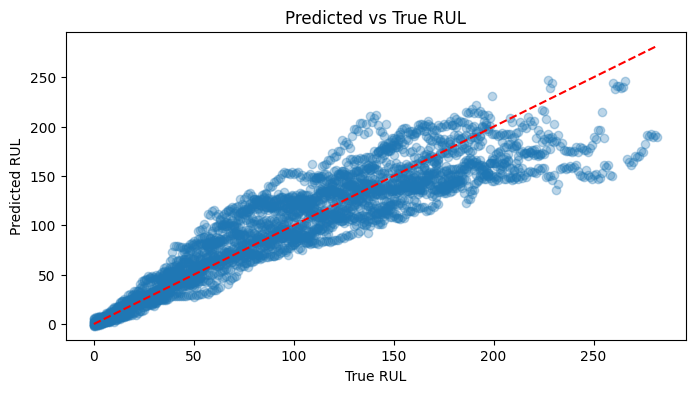

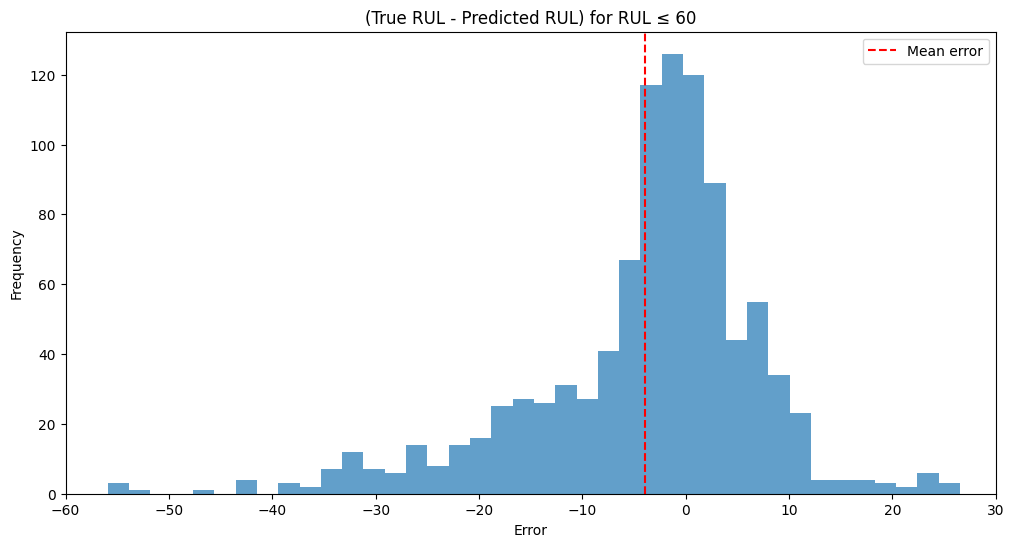

weighted MAE: 14.84


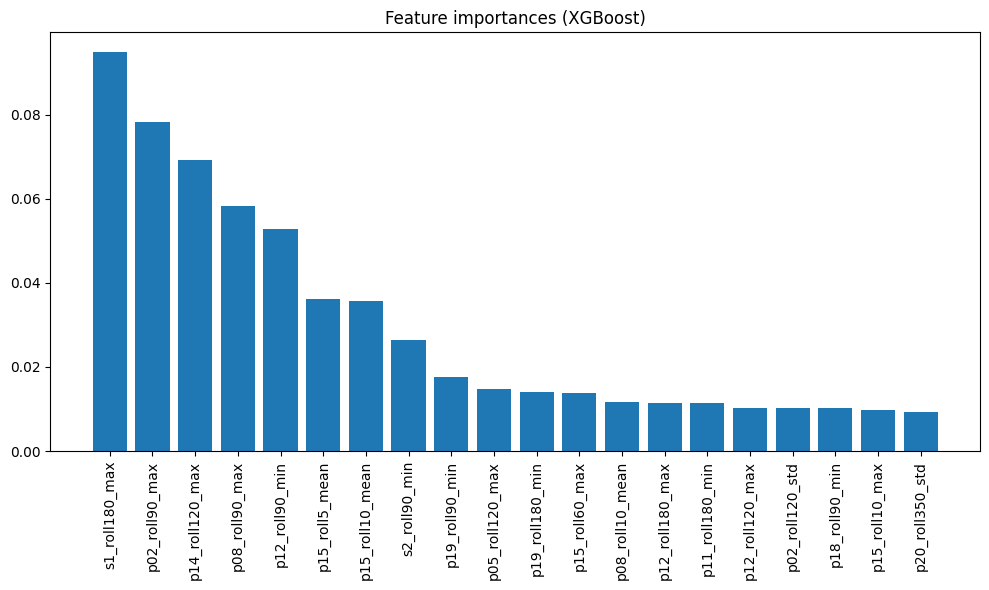

In [28]:
print_metrics(y_test, y_pred_xgb)
plot_feature_importances(model_xgb, X_train)

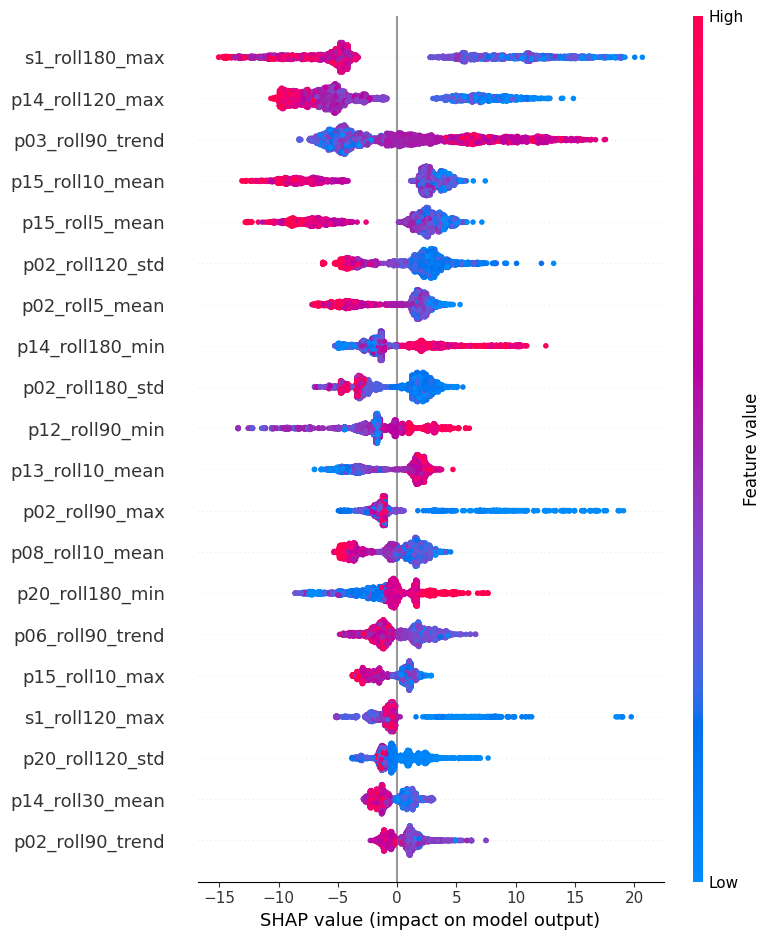

In [34]:
from IPython.display import display

def plot_shap_values(model, X_test):
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test)

    # Summary plot
    shap.summary_plot(shap_values, X_test, max_display=20)


plot_shap_values(model_xgb, X_test)


# 7. Baseline Catboost Model

In [35]:
# CatBoost
from catboost import CatBoostRegressor

model_cat = CatBoostRegressor(early_stopping_rounds=50, iterations=1000, learning_rate=0.1, depth=5, random_seed=42, verbose=100)

model_cat.fit(X_train, y_train)
y_pred_cat = model_cat.predict(X_test)

print("\nCatBoost:")
for i in range(5):
    print(f"Predicted RUL: {y_pred_cat[i]:.1f}, True RUL: {y_test.iloc[i]}")

0:	learn: 62.1172282	total: 197ms	remaining: 3m 16s
100:	learn: 10.3546519	total: 8.37s	remaining: 1m 14s
200:	learn: 6.5639430	total: 16.8s	remaining: 1m 6s
300:	learn: 4.9596912	total: 24.1s	remaining: 56.1s
400:	learn: 4.0554976	total: 31.8s	remaining: 47.5s
500:	learn: 3.5003843	total: 39.3s	remaining: 39.1s
600:	learn: 3.1190792	total: 46.7s	remaining: 31s
700:	learn: 2.8203175	total: 53.7s	remaining: 22.9s
800:	learn: 2.5795276	total: 1m	remaining: 15.1s
900:	learn: 2.3804827	total: 1m 8s	remaining: 7.49s
999:	learn: 2.2130103	total: 1m 15s	remaining: 0us

CatBoost:
Predicted RUL: 187.0, True RUL: 194
Predicted RUL: 183.4, True RUL: 193
Predicted RUL: 201.0, True RUL: 192
Predicted RUL: 196.0, True RUL: 191
Predicted RUL: 216.1, True RUL: 190


MAE (all): 18.84
RMSE (all): 26.13

Range RUL <=60:
  MAE: 8.05
  RMSE: 11.40

Range RUL 60-100:
  MAE: 19.06
  RMSE: 24.07

Range RUL 100-200:
  MAE: 21.00
  RMSE: 25.28

Range RUL >200:
  MAE: 53.03
  RMSE: 60.90


/tmp/ipykernel_56716/4037183417.py:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', color='red')


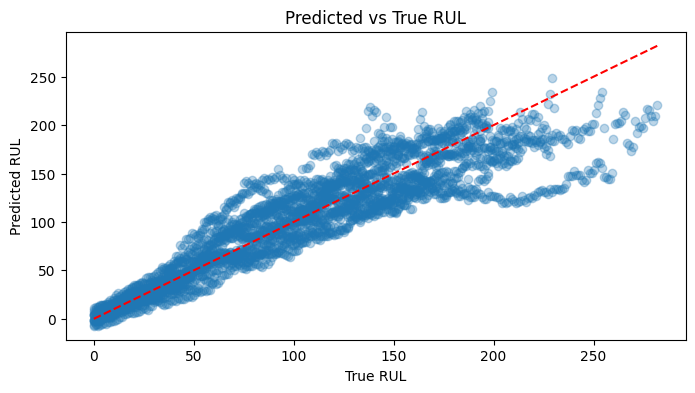

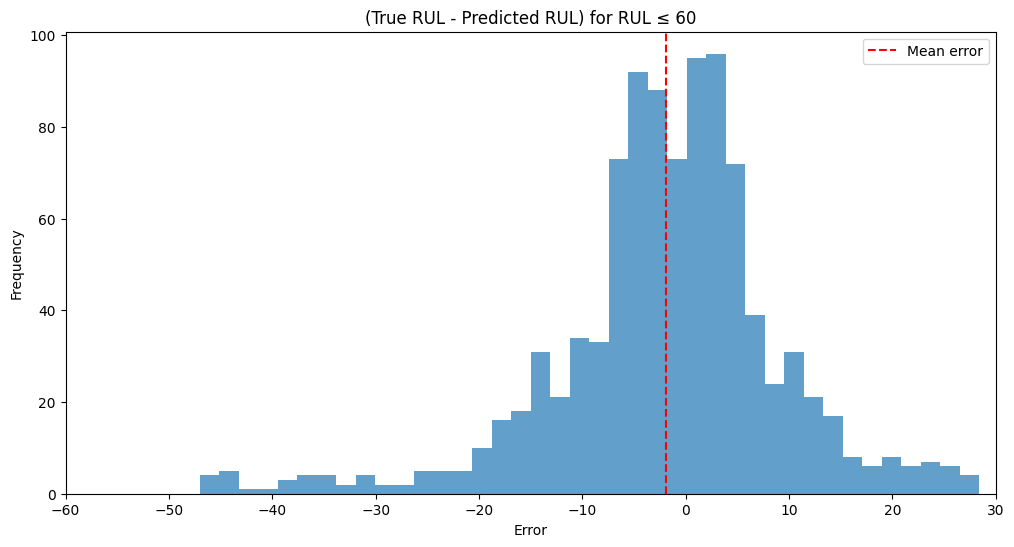

weighted MAE: 14.72


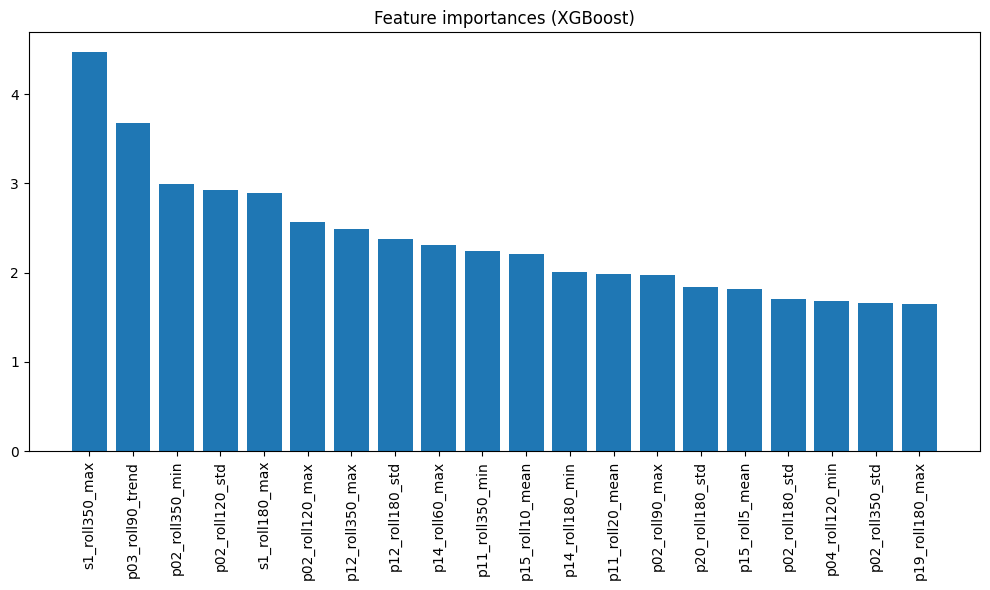

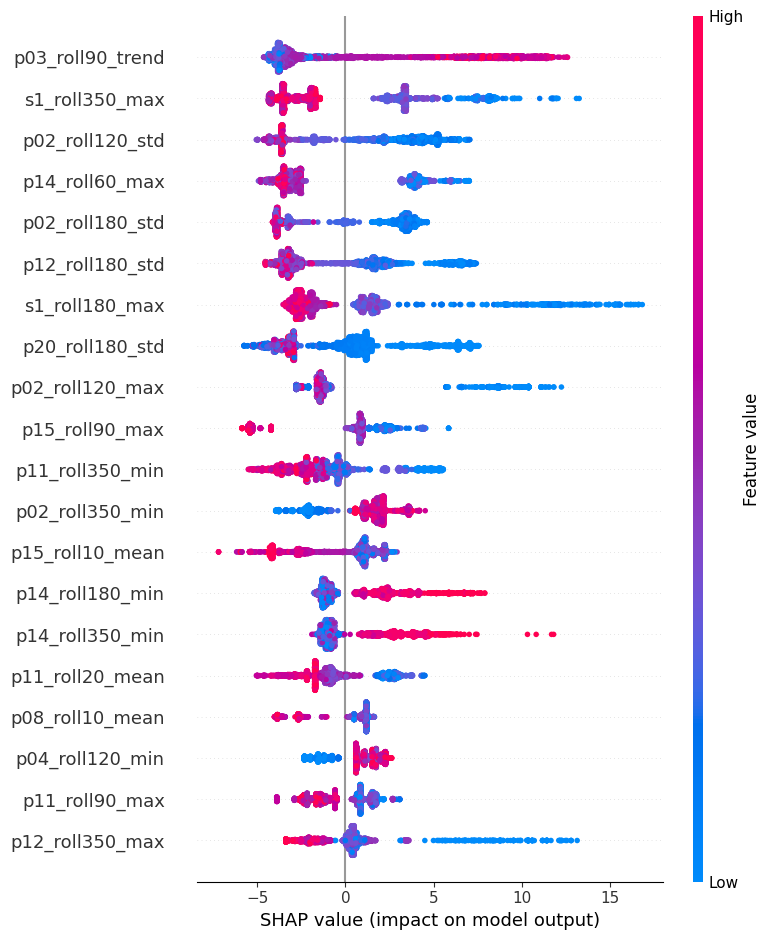

In [36]:
print_metrics(y_test, y_pred_cat)
plot_feature_importances(model_cat, X_train)
plot_shap_values(model_cat, X_test)

Our graph shows the following:  
  
The average error (red dotted line) is negative, i.e. the model overestimates the remaining service life on average (predicts more than it actually is).  
  
Distribution of errors - most errors are in the range from -10 to 10, but there is a long left tail (errors up to -50), i.e. sometimes the model is very wrong in the direction of overestimating the service life.  
  
Practical conclusion:  
The model tends to be "optimistic" - it often believes that the engine will last longer than it actually does. This is dangerous for operation, since you may not have time to replace or service the engine in time.
Recommendation:  
It is worth refining the model or adding a penalty for overestimating the service life to reduce the negative bias of the error.  

# 8. Let's add a penalty for resource overvaluation


In [37]:
def custom_asymmetric_loss(y_true, y_pred):
    # y_true и y_pred — numpy массивы
    residual = y_true - y_pred
    grad = np.where(residual < 0, -2, -1) * np.sign(residual)  # 5 — a penalty for underestimation 
    hess = np.ones_like(residual)
    return grad, hess

model_xgb_penalty = xgb.XGBRegressor(
    n_estimators=1000,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    objective=custom_asymmetric_loss
)
model_xgb_penalty.fit(X_train, y_train)

,objective,<function cus...x74248b226a20>
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


MAE (all): 19.00
RMSE (all): 26.13

Range RUL <=60:
  MAE: 8.16
  RMSE: 12.01

Range RUL 60-100:
  MAE: 19.11
  RMSE: 24.26

Range RUL 100-200:
  MAE: 21.27
  RMSE: 25.52

Range RUL >200:
  MAE: 53.16
  RMSE: 59.55


/tmp/ipykernel_56716/4037183417.py:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', color='red')


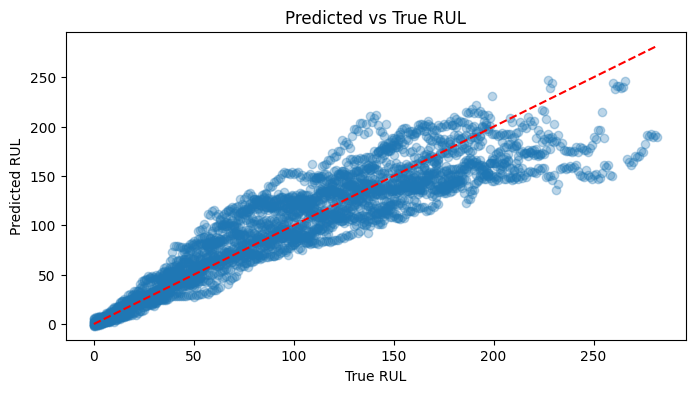

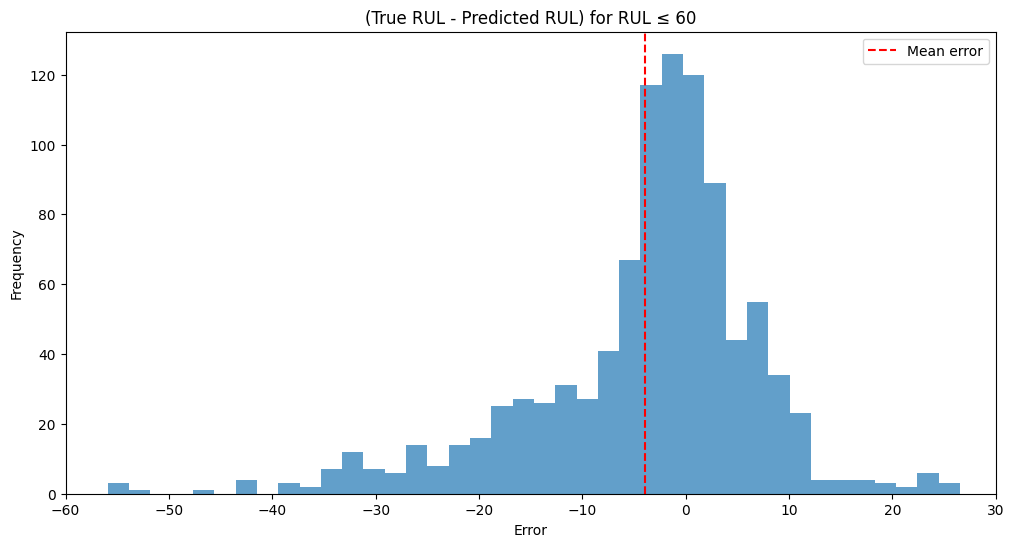

weighted MAE: 14.84


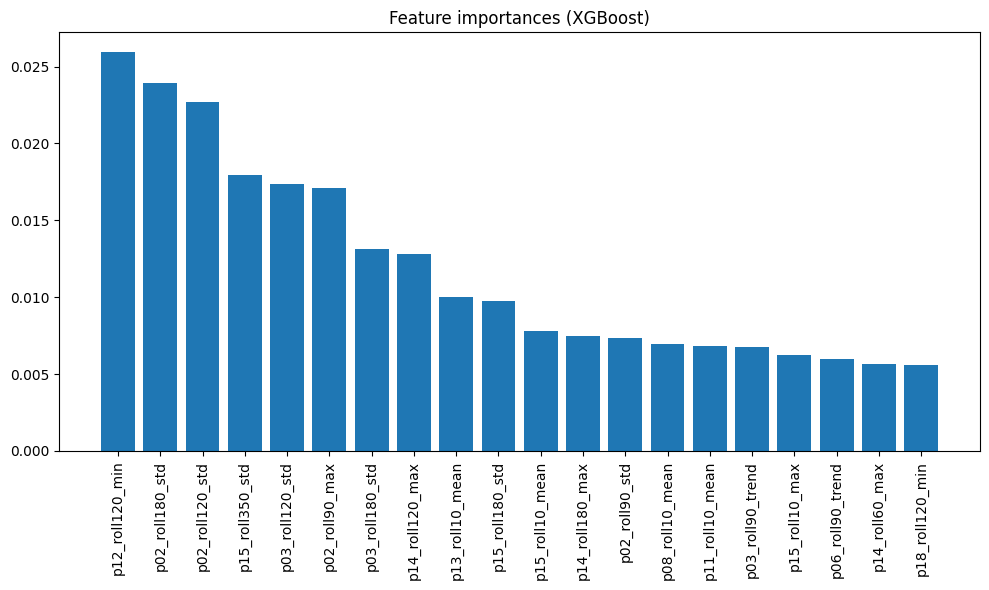

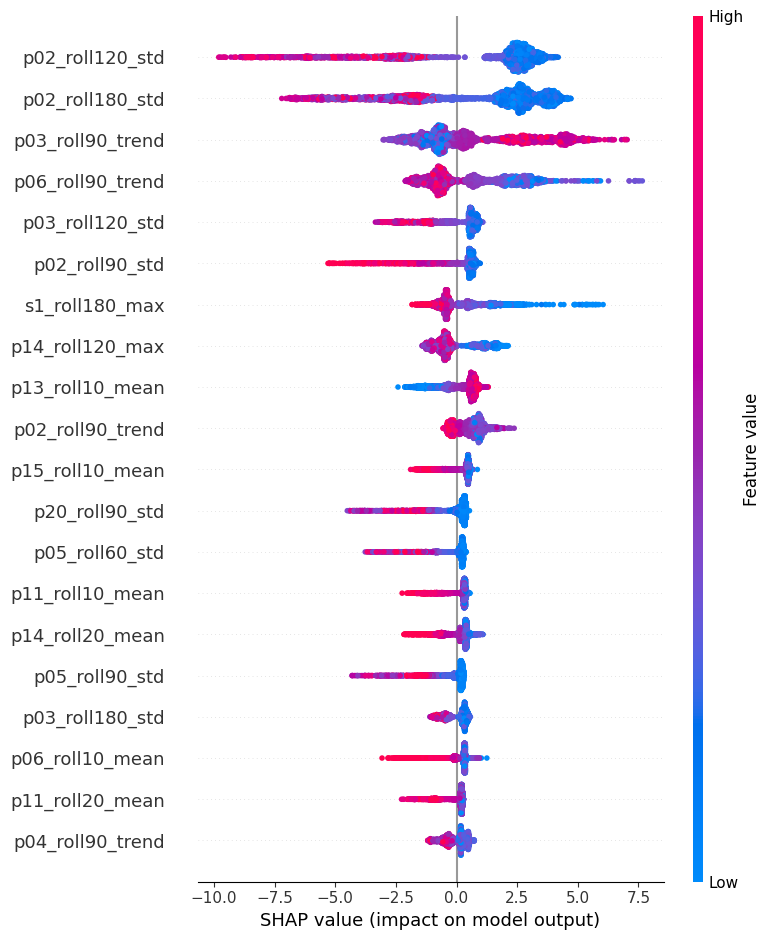

In [38]:
print_metrics(y_test, y_pred_xgb)
plot_feature_importances(model_xgb_penalty, X_train)
plot_shap_values(model_xgb_penalty, X_test)